# Note: I have made one notebook for all three questions

# Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto

For this assignment, you will be required to explore and cluster the neighborhoods in Toronto.

1.
Start by creating a new Notebook for this assignment. 
COMPLETE

2.
Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe like the one shown below:


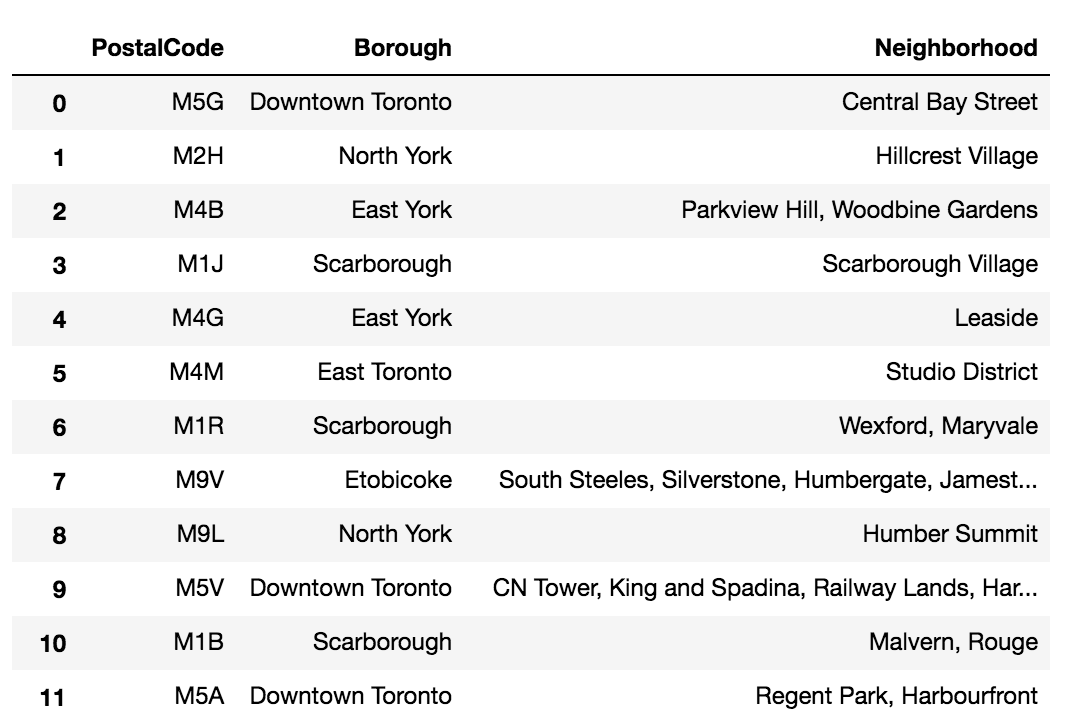

# Part 1
## 1.1 Create the notebook for the assignment

In [166]:
import requests # library to handle requests
import lxml.html as lh
import bs4 as bs
import urllib.request

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

For this assignment, you will be required to explore and cluster the neighborhoods in Toronto.

Start by creating a new Notebook for this assignment.
Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe like the one shown above:

## 1.2 Web Page Scraping

In [167]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [168]:
# Using BS4.

def scrape_table_bs4(cname,cols):
    page  = urllib.request.urlopen(url).read()
    soup  = bs.BeautifulSoup(page,'lxml')
    table = soup.find("table",class_=cname)
    header = [head.findAll(text=True)[0].strip() for head in table.find_all("th")]
    data   = [[td.findAll(text=True)[0].strip() for td in tr.find_all("td")]
              for tr in table.find_all("tr")]
    data    = [row for row in data if len(row) == cols]
    # Store data to this temporary dataframe
    raw_df = pd.DataFrame(data,columns=header)
    return raw_df

In [169]:
raw_TorontoPostalCodes = scrape_table_bs4("wikitable",3)
raw_TorontoPostalCodes.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


## Cleaning the Data Frame

# To create the dataframe:

* The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood

* Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

* More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

* If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.

* Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.

* In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

## Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

In [170]:
#Remove cells with a borough that is Not Assigned
TorontoPostalCodes=raw_TorontoPostalCodes[~raw_TorontoPostalCodes['Borough'].isin(['Not assigned'])]

# Sort and Reset index.
TorontoPostalCodes=TorontoPostalCodes.sort_values(by=['Postcode','Borough','Neighbourhood'], ascending=[1,1,1]).reset_index(drop=True)
TorontoPostalCodes.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,Malvern
1,M1B,Scarborough,Rouge
2,M1C,Scarborough,Highland Creek
3,M1C,Scarborough,Port Union
4,M1C,Scarborough,Rouge Hill


In [171]:
TorontoPostalCodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 3 columns):
Postcode         211 non-null object
Borough          211 non-null object
Neighbourhood    211 non-null object
dtypes: object(3)
memory usage: 5.0+ KB


## If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

In [172]:
TorontoPostalCodes.loc[TorontoPostalCodes['Neighbourhood'] == 'Not assigned', ['Neighbourhood']] = TorontoPostalCodes['Borough']
check_unassigned_post_state_sample = TorontoPostalCodes.loc[TorontoPostalCodes['Borough'] == 'Queen\'s Park']
print('DEBUG:',check_unassigned_post_state_sample)

DEBUG:     Postcode       Borough Neighbourhood
159      M7A  Queen's Park  Queen's Park


## More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

In [173]:
TorontoPostalCodes = TorontoPostalCodes.groupby(['Postcode','Borough'])['Neighbourhood'].apply(', '.join).reset_index()

In [174]:
TorontoPostalCodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 3 columns):
Postcode         103 non-null object
Borough          103 non-null object
Neighbourhood    103 non-null object
dtypes: object(3)
memory usage: 2.5+ KB


In [175]:
TorontoPostalCodes.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


## Toronto Postal Codes row and column counts

## Part 1 Answer:

In [176]:
TorontoPostalCodes.shape

(103, 3)

# Part 2

## Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

In an older version of this course, we were leveraging the Google Maps Geocoding API to get the latitude and the longitude coordinates of each neighborhood. However, recently Google started charging for their API: http://geoawesomeness.com/developers-up-in-arms-over-google-maps-api-insane-price-hike/, so we will use the Geocoder Python package instead: https://geocoder.readthedocs.io/index.html.

The problem with this Package is you have to be persistent sometimes in order to get the geographical coordinates of a given postal code. So you can make a call to get the latitude and longitude coordinates of a given postal code and the result would be None, and then make the call again and you would get the coordinates. So, in order to make sure that you get the coordinates for all of our neighborhoods, you can run a while loop for each postal code. Taking postal code M5G as an example, your code would look something like this:

Given that this package can be very unreliable, in case you are not able to get the geographical coordinates of the neighborhoods using the Geocoder package, here is a link to a csv file that has the geographical coordinates of each postal code: http://cocl.us/Geospatial_data

Use the Geocoder package or the csv file to create the following dataframe:

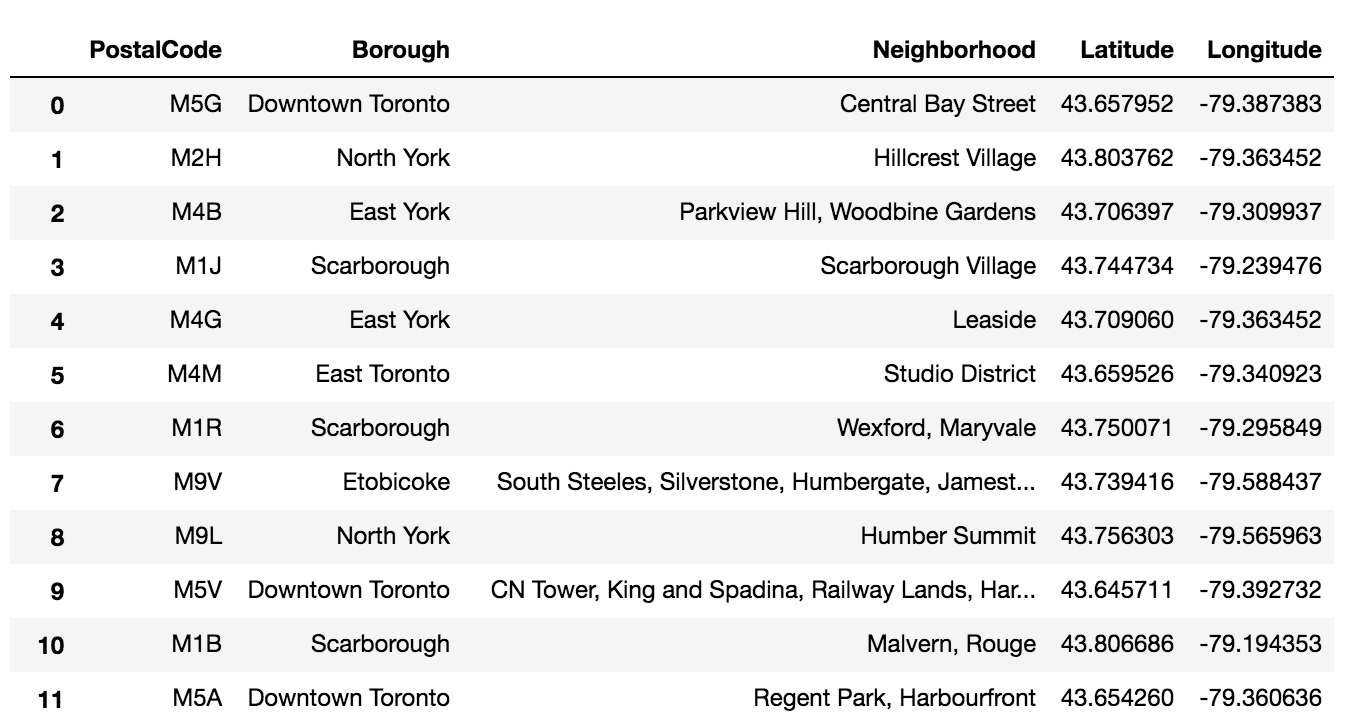

In [177]:
# we need to rename the Postcode column to Postal Code
TorontoPostalCodes = TorontoPostalCodes.set_index("Postcode")
TorontoPostalCodes.rename_axis("Postal Code", axis='index', inplace=True)
TorontoPostalCodes.head()

,Borough,Neighbourhood
Postal Code,,
M1B,Scarborough,"Malvern, Rouge"
M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill"
M1E,Scarborough,"Guildwood, Morningside, West Hill"
M1G,Scarborough,Woburn
M1H,Scarborough,Cedarbrae


# Use the Geocoder package or the csv file to create dataframe with longitude and latitude values

In [178]:
toronto_geocsv = 'https://cocl.us/Geospatial_data'
!wget -q -O 'toronto_m.geospatial_data.csv' toronto_geocsv
geocsv_data = pd.read_csv(toronto_geocsv).set_index("Postal Code")
geocsv_data.head()

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


## Next we combine the two data frame with postcodes

In [179]:
toronto_neighborhoods = TorontoPostalCodes.join(geocsv_data)
toronto_neighborhoods.head()

,Borough,Neighbourhood,Latitude,Longitude
Postal Code,,,,
M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497
M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
M1G,Scarborough,Woburn,43.770992,-79.216917
M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# Part 2 Answer

In [182]:
toronto_neighborhoods[0:11]

,Borough,Neighbourhood,Latitude,Longitude
Postal Code,,,,
M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497
M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
M1G,Scarborough,Woburn,43.770992,-79.216917
M1H,Scarborough,Cedarbrae,43.773136,-79.239476
M1J,Scarborough,Scarborough Village,43.744734,-79.239476
M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476


# Part 3

Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you.

Just make sure:

to add enough Markdown cells to explain what you decided to do and to report any observations you make.
to generate maps to visualize your neighborhoods and how they cluster together.

In [184]:
#!conda install -c conda-forge geopy --yes        # if needed
#!conda install -c conda-forge folium=0.5.0 --yes # if needed

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files


from geopy.geocoders import Nominatim 
GeoLocator = Nominatim(user_agent='My-IBMNotebook')# convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

In [185]:
toronto_neighborhoods.head()

,Borough,Neighbourhood,Latitude,Longitude
Postal Code,,,,
M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497
M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
M1G,Scarborough,Woburn,43.770992,-79.216917
M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Get the latitude and longitude values of Toronto Canada

In [187]:
address = 'Toronto, Ontario Canada'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto Canada are 43.653963, -79.387207.


## Create a map of Toronto with neighborhoods superimposed

In [188]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_neighborhoods['Latitude'], toronto_neighborhoods['Longitude'], toronto_neighborhoods['Borough'], toronto_neighborhoods['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#87cefa',
        fill_opacity=0.5,
        parse_html=False).add_to(map_toronto)

In [189]:
map_toronto

For this task, We will focus our analysis to Neighbohoods in East,West and Central Toronto only. Lets just take portion of dataframe where Boroughs contain word Toronto.

In [190]:
toronto_data = toronto_neighborhoods[toronto_neighborhoods['Borough'].str.contains("Toronto")].reset_index(drop=True)
print(toronto_data.shape)
toronto_data.head()

(38, 4)


,Borough,Neighbourhood,Latitude,Longitude
0,East Toronto,The Beaches,43.676357,-79.293031
1,East Toronto,"Riverdale, The Danforth West",43.679557,-79.352188
2,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,East Toronto,Studio District,43.659526,-79.340923
4,Central Toronto,Lawrence Park,43.728020,-79.388790


## Create a new map with the new markers

In [192]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Utilizing the Foursquare API to explore and segment neighborhoods

CLIENT_ID = 'portion hidden from view' # your Foursquare ID <br/>
CLIENT_SECRET = 'portion hidden from view' # your Foursquare Secret <br/>
VERSION = '20180604' <br/>
LIMIT = 30 <br/>
print('Your credentails:')<br/>
print('CLIENT_ID: ' + CLIENT_ID)<br/>
print('CLIENT_SECRET:' + CLIENT_SECRET)<br/>

In [194]:
# @hidden
CLIENT_ID = 'CVFZIHHKFIYX5VCCCJJLKGBEKGTCXA2VLQOCMFTXJNFRMIS2' # your Foursquare ID
CLIENT_SECRET = 'IHUGWTRHYEUYIZOP1UAMJKI1FAWCPHI5H22SAHAR1WGF1TXZ' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CVFZIHHKFIYX5VCCCJJLKGBEKGTCXA2VLQOCMFTXJNFRMIS2
CLIENT_SECRET:IHUGWTRHYEUYIZOP1UAMJKI1FAWCPHI5H22SAHAR1WGF1TXZ
